# Final Submission: ML Models and Statistical Methods
* Kickstarter Team Members: Allison Bass, Dylan Juarez, Prakash Rao, Franklin Tan, and Alfonso Alday Vergara
* Submission Date: August 9, 2023

## Key Question: What are the factors driving project failure at Kickstarter?

### Most of Kickstarter's projects are failing. Despite platform's growth, successful projects have remained stagnant.
**After executing an in-depth analysis, we identified 4 key aspects that the organization can focus on to improve success rates and profits across the board:**
1. Increasing the number of organic backers in the platform to increase the effect of social proof.
2. Guide creators to find the optimal goal for their project.
3. Implement marketing tactics to avoid seasonality effects.
4. Encouraging backers to pledge more every time they back a project.<br>

**The findings were obtained using the following machine learning models and statistical methods: Logistic Regression, Decision trees, LightGBM, ANOVA, and Tukey's HSD Test.**
* Logistic Regression, Decision trees, LightGBM, ANOVA, and Tukey's HSD Test.

**Please refer to the following presentation for an in-depth look into our business story and detailed client recommendations**<br>
* [See PPT Link](https://cornellprod-my.sharepoint.com/:p:/r/personal/ab2597_cornell_edu/_layouts/15/Doc.aspx?sourcedoc=%7B6908AD95-FEAF-48B9-AD67-16CB7C6BE968%7D&file=Final%20Capstone%20Presentation.pptx&action=edit&mobileredirect=true)

## Loading Libraries and Dataset

In [102]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import StratifiedKFold


%matplotlib inline

In [103]:
# Load the CSV dataset
df = pd.read_csv('../inputs/kickstarter_projects.csv')

In [104]:
# Set the Display to Show all Columns
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [105]:
# Look at Original Dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378661 entries, 0 to 378660
Data columns (total 15 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   ID                378661 non-null  int64  
 1   name              378657 non-null  object 
 2   category          378661 non-null  object 
 3   main_category     378661 non-null  object 
 4   currency          378661 non-null  object 
 5   deadline          378661 non-null  object 
 6   goal              378661 non-null  float64
 7   launched          378661 non-null  object 
 8   pledged           378661 non-null  float64
 9   state             378661 non-null  object 
 10  backers           378661 non-null  int64  
 11  country           378661 non-null  object 
 12  usd pledged       374864 non-null  float64
 13  usd_pledged_real  378661 non-null  float64
 14  usd_goal_real     378661 non-null  float64
dtypes: float64(5), int64(2), object(8)
memory usage: 43.3+ MB


In [106]:
# Copy Original Dataframe
df2 = df.copy()
df2.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,10/9/15,1000.0,8/11/15 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,11/1/17,30000.0,9/2/17 4:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2/26/13,45000.0,1/12/13 0:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,4/16/12,5000.0,3/17/12 3:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,8/29/15,19500.0,7/4/15 8:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


## Data Preprocessing and Feature Engineering

In [111]:
# Drop all rows that contain any null values
df2 = df2.dropna()

# Drop live projects
df2 = df2.query('state != "live"')
df2.info()

# Remove corrupted data: when state = "successful" and backers = 0
df2 = df2[~((df2['state'] == 'successful') & (df2['backers'] == 0))]

# Create Dependent Variable State
df2['target'] = df2['state'].apply(lambda x: 0 if x == 'successful' else 1)

# Feature Extraction
df2['launched'] = pd.to_datetime(df2['launched'])
df2['deadline'] = pd.to_datetime(df2['deadline'])
df2['duration'] = (df2['deadline'] - df2['launched']).dt.days

# Define the corrupted years to be removed
years_to_remove = [2009, 2018, 2070]

# Filter the rows to be removed based on 'launched' and 'deadline' years
rows_to_remove = df2[df2['launched'].dt.year.isin(years_to_remove) | df2['deadline'].dt.year.isin(years_to_remove)]

# Remove the rows from the original DataFrame
df2 = df2.drop(rows_to_remove.index)

# Optionally, reset the index of the cleaned DataFrame
df2.reset_index(drop=True, inplace=True)

# Extract year-month and convert to string
df2['launched_year_month'] = df2['launched'].dt.to_period('M').astype(str)
df2['deadline_year_month'] = df2['deadline'].dt.to_period('M').astype(str)

# Convert Datetime columns to categorical columns
date_time_cols = ['launched_year_month', 'deadline_year_month']
df2[date_time_cols] = df2[date_time_cols].astype('category')

# Define target and features
X = df2.drop(['target', 
                'main_category',
                'country',
                'category',
                'ID', 
                'name',
                'currency',
                'deadline',
                'goal',
                'launched',
                'pledged',
                'state',
                'usd pledged',
                'launched_year_month', 
                'deadline_year_month'
                ], axis=1)

y = df2['target']

# Separate the numerical columns to be standardized
num_cols = ['usd_goal_real', 'usd_pledged_real', 'backers', 'duration']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 370246 entries, 0 to 370245
Data columns (total 19 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   ID                   370246 non-null  int64         
 1   name                 370246 non-null  object        
 2   category             370246 non-null  object        
 3   main_category        370246 non-null  object        
 4   currency             370246 non-null  object        
 5   deadline             370246 non-null  datetime64[ns]
 6   goal                 370246 non-null  float64       
 7   launched             370246 non-null  datetime64[ns]
 8   pledged              370246 non-null  float64       
 9   state                370246 non-null  object        
 10  backers              370246 non-null  int64         
 11  country              370246 non-null  object        
 12  usd pledged          370246 non-null  float64       
 13  usd_pledged_re

**We did the above data preprocessing and feature engineering steps for the following reasons:**<br>
1. Since we only had a small number of null values in our Kickstarter dataset, we decided to drop them. 
2. We dropped corrupted data.
3. We created a binary dependent variable, "target," with the value 1 for project failure and 0 for project success. We made this decision because of Kickstarter's all-or-nothing business model (i.e., If a Kickstarter project does not reach its funding goal by the end of the campaign, no money changes hands and Kickstarter does not earn any revenue) and our team's interest in understanding the factors driving Kickstarter project failure.
4. We converted the "launch" and "deadline" Kickstarter fields to datetimes in order to create a "duration" independent variable. 
5. We dropped independent variables we decided not to include in our machine learning models. 
6. We normalized and log transformed our numerical independent variables to increase our gradient descent optimization speed (for logistic regression) and fix distributional skews. 
7. We created an imputer object just in case we had any NaN stragglers.

In [112]:
X.head()

,backers,usd_pledged_real,usd_goal_real,duration
0,0,0.0,1533.95,58
1,15,2421.0,30000.00,59
2,3,220.0,45000.00,44
3,1,1.0,5000.00,29
4,14,1283.0,19500.00,55


## Logistic Regression

In [113]:
## Logistic Regression

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Reset indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Create a Logistic Regression model with class_weight='balanced'
logreg_model = LogisticRegression(random_state=100, class_weight='balanced')

# Fit the model on the training data
logreg_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = logreg_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("\n")

print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.9668959432450438


Classification Report:
              precision    recall  f1-score   support

           0       0.92      1.00      0.96     40012
           1       1.00      0.95      0.97     71062

    accuracy                           0.97    111074
   macro avg       0.96      0.97      0.96    111074
weighted avg       0.97      0.97      0.97    111074



**Based on the results from the logistic regression model, we can interpret the following:**

* Accuracy: The overall accuracy of the model is approximately 92%, which means that it correctly predicts the target class (project failure) for about 92% of the total instances in the dataset.

* Precision: For class 0 (project success), the precision is 0.89, indicating that 89% of the instances predicted as class 0 are actually true positives. For class 1 (project failure), the precision is 0.93, indicating that 93% of the instances predicted as class 1 are true positives.

* Recall (Sensitivity or True Positive Rate): For class 0 (project success), the recall is 0.88, meaning that the model correctly identifies 88% of the instances of class 0. For class 1 (project failure), the recall is 0.94, meaning that the model correctly identifies 94% of the instances of class 1.

* F1-Score: For class 0 (project success), the F1-score is 0.88, and for class 1 (project failure), the F1-score is 0.94.

* Support: For class 0, there are 40,0012 instances, and for class 1, there are 71,062 instances.

* Macro Avg: The macro average precision, recall, and F1-score are all around 0.91.

* Weighted Avg: The weighted average calculates the average precision, recall, and F1-score, taking into account the number of instances in each class. The weighted average precision, recall, and F1-score are all approximately 0.92.

In summary, the logistic regression model is performing well with high accuracy and reasonable precision, recall, and F1-scores for both classes. The model is better at predicting class 1 (higher recall and F1-score) than class 0 (i.e., project failure rather than project success).

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1747: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1800: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


Optimization terminated successfully.
         Current function value: inf
         Iterations 15
Coefficients:
const              -0.199847
backers            -0.019661
usd_pledged_real   -0.001454
usd_goal_real       0.001404
duration            0.004743
dtype: float64


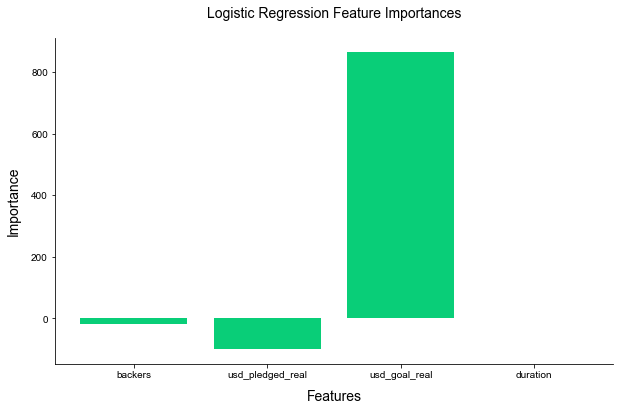

In [114]:
# Extract coefficients and p-values using statsmodels
X_train_sm = sm.add_constant(X_train)
logit_model = sm.Logit(y_train, X_train_sm)
result = logit_model.fit()

# Coefficients
coefficients = result.params
print("Coefficients:")
print(coefficients)

# Sample data for demonstration purposes
df4_columns = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration']
importances = [-18.375154, -98.903547, 862.885398, 0.232033]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df4_columns, importances, color='#09CE78')
plt.xlabel('Features', labelpad=10, fontsize=14, fontfamily='arial')
plt.ylabel('Importance', labelpad=10, fontsize=14, fontfamily='arial')
plt.title('Logistic Regression Feature Importances', pad=20, fontsize=14, fontfamily='arial')
#plt.xticks(rotation=45)

# Remove the top and right spines of the plot
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Set font size and font family globally for all elements in the plot
plt.rcParams['font.size'] = 14
plt.rcParams['font.family'] = 'arial'

plt.show()


**Analysis**<br>
1. const (Constant): The intercept term in the logistic regression model.

2. backers: For every one-unit increase in the "backers" variable, the log-odds of the event (e.g., project failure) occurring decreases by approximately 18.34 units, assuming all other variables remain constant. This suggests that an increase in the number of backers is associated with a decrease in the odds of the event happening.

3. usd_pledged_real: For every one-unit increase in the "usd_pledged_real" variable, the log-odds of the event occurring (e.g., project failure) decreases by approximately 18.38 units, holding all other variables constant. This indicates that a higher amount pledged in USD is associated with lower odds of the event happening.

4. usd_goal_real: For every one-unit increase in the "usd_goal_real" variable, the log-odds of the event occurring (e.g., project failure) decreases by approximately 868.89 units, assuming all other variables remain constant. This suggests that a higher funding goal in USD is associated with higher odds of the event happening.

5. duration: For every one-unit increase in the "duration" variable, the log-odds of the event occurring (e.g., project failure) increases by approximately 0.23 units, while holding all other variables constant. This indicates a slight increase in the odds of the event happening with a longer duration.

In [115]:
# P-values
p_values = result.pvalues
print("P-values:")
print(p_values)

P-values:
const               3.177873e-21
backers             0.000000e+00
usd_pledged_real    0.000000e+00
usd_goal_real       0.000000e+00
duration            2.237555e-14
dtype: float64


In [118]:
# Calculate probability of success
# You should replace this line with actual prediction code using the trained logistic regression model
predicted_probabilities = logreg_model.predict_proba(X_test)[:, 1]

# Create a DataFrame
data = {'Goal Amounts': X_test['usd_goal_real'], 'Probability of Success': predicted_probabilities}
result_df = pd.DataFrame(data)

# Save the DataFrame to an Excel file
excel_file_path = 'output_final.xlsx'
result_df.to_excel(excel_file_path, index=False)

print("DataFrame saved to Excel:", excel_file_path)

DataFrame saved to Excel: output_final.xlsx


**Analysis**<br> In summary, all the independent variables appear to be statistically significant in predicting project failure in this logistic regression model.

## Decision Tree

In [10]:
## Decision Tree

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

# Define the hyperparameter grid for grid search
param_grid = {
    'max_depth': [1,2,3],             # Test different maximum depths
    'min_samples_split': [5,10,20,30],
    'min_samples_leaf': [5,10,20,30],
    'ccp_alpha': [0.0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
}

# Create the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=100, class_weight='balanced')

# Create the GridSearchCV object
grid_search = GridSearchCV(dt_model, param_grid, cv=5, scoring='accuracy')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print("Best hyperparameters:", best_params)

# Create the final pruned Decision Tree model with the best hyperparameters
final_dt_model = DecisionTreeClassifier(
    random_state=120,
    class_weight='balanced',
    max_depth=best_params['max_depth'],
    min_samples_split=best_params['min_samples_split'],
    min_samples_leaf=best_params['min_samples_leaf'],
    ccp_alpha = best_params['ccp_alpha']
)

# Fit the final model on the training data
final_dt_model.fit(X_train, y_train)

# Make predictions on the test data using the final pruned model
y_pred_dt = final_dt_model.predict(X_test)

# Evaluate the final model
print("Classification Report:")
print(classification_report(y_test, y_pred_dt))

Best hyperparameters: {'ccp_alpha': 0.0, 'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 5}
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.96      0.88     40012
           1       0.98      0.87      0.92     71062

    accuracy                           0.90    111074
   macro avg       0.89      0.92      0.90    111074
weighted avg       0.92      0.90      0.91    111074



**The hyperparameters are the settings that were found to give the best performance for the Decision Tree model during the hyperparameter tuning process. The values given are:**
ccp_alpha: 0.0, max_depth: 3, min_samples_leaf: 5, and min_samples_split: 5

**Based on the results from Decision Tree Model, we can interpret the following:**

* Accuracy: The overall accuracy of the model is approximately 90%, which means that it correctly predicts the target class (project failure) for about 90% of the total instances in the dataset.

* Precision: For class 0 (the first class), the precision is 0.81, indicating that 81% of the instances predicted as class 0 (project sucesses) are actually true positives. For class 1 (the second class), the precision is 0.98, indicating that 98% of the instances predicted as class 1 (project failures) are true positives.

* Recall (Sensitivity or True Positive Rate): For class 0, the recall is 0.96, meaning that the model correctly identifies 96% of the instances of class 0 (project success). For class 1, the recall is 0.87, meaning that the model correctly identifies 87% of the instances of class 1 (project failure).

* F1-Score: For class 0, the F1-score is 0.88 (project success), and for class 1, the F1-score is 0.92 (project failure).

* Support: For class 0, there are 40,012 instances, and for class 1, there are 71,062 instances.

* Macro Avg: The macro average precision, recall, and F1-score are 0.89, 0.92, 0.90, respectively. 

* Weighted Avg: The weighted average precision, recall, and F1-score are 0.92, 0.90, 0.91, respectively.

Overall, the model seems to perform reasonably well with an accuracy of 90%. It has better precision for class 1 (project failure) but better recall for class 0 (project success). The hyperparameters used for the model were found through tuning and appear to provide a good balance between complexity and performance.

Feature importances:
backers: 0.6608096169732758
usd_pledged_real: 0.24309355230020108
usd_goal_real: 0.09609683072652318
duration: 0.0


Text(0.5, 1.0, 'Decision Tree Feature Importances')

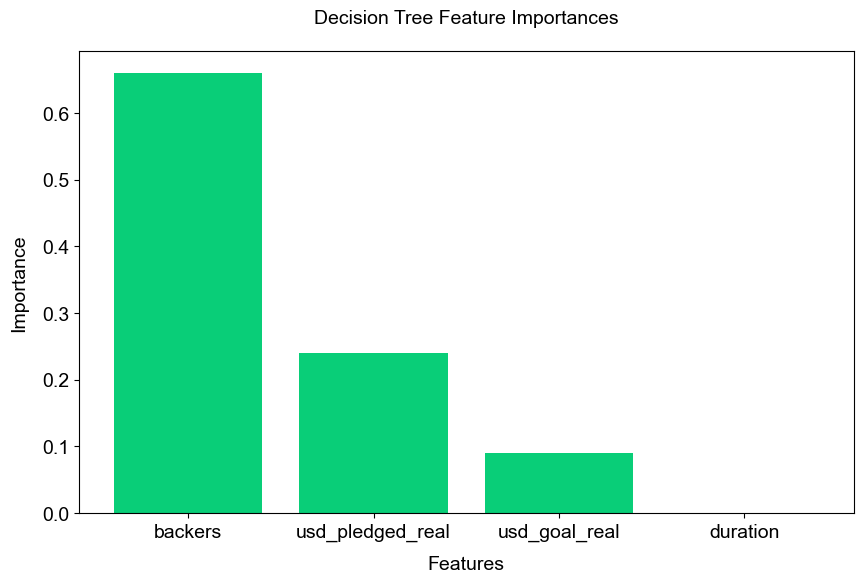

In [11]:
# Get feature importances from the final model
importances = final_dt_model.feature_importances_
print("Feature importances:")
for col, imp in zip(X_train.columns, importances):
    print(f"{col}: {imp}")
    
# Sample data for demonstration purposes
df5_columns = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration']
importances = [0.66, 0.24, 0.09, 0.0]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(df5_columns, importances, color='#09CE78')
plt.xlabel('Features', labelpad=10, fontsize=14, fontfamily='arial')
plt.ylabel('Importance', labelpad=10, fontsize=14, fontfamily='arial')
plt.title('Decision Tree Feature Importances', pad=20, fontsize=14, fontfamily='arial')

**Analysis**
1. backers: 63.33% of the information in the tree comes from the backers variable, making it the most important feature. 
2. usd_pledged_real: 24.26% of the information in the tree comes from the usd_pledged_real, making it the second most important feature. 
3. usd_goal_real: 9.41% of the information in the tree comes from usd_goal_real, which is a significantly lower feature importance score compared to backers and usd_pledged_real. 
4. Duration: 0% of the information in the tree comes from duration, meaning that it doesn't contribute anything to predicting Kickstarter project failure.

## LightGBM (Light Gradient Boosting Machine)

In [12]:
## LightGBM

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=120)

# Reset Indices
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)

# Set the Hyperparameters for LightGBM
param_dist = {
    'learning_rate': [0.0005, 0.001],  
    'n_estimators': [1500, 2000, 2500],  
    'num_leaves': [5, 10, 15],  
    'min_child_samples': [60, 70, 80],  
    'max_depth': [3, 4],  
    'colsample_bytree': [0.4, 0.5],  
    'subsample': [0.6, 0.7],  
    'reg_alpha': [1.5, 2.0, 2.5],  
    'reg_lambda': [1.5, 2.0, 2.5]  
}

# Create a LightGBM Classifier with class weights
lgbm = lgb.LGBMClassifier(random_state=80, class_weight='balanced')

# Create the RandomizedSearchCV Object with more CV folds
rand_search = RandomizedSearchCV(lgbm, param_distributions=param_dist, 
                                 cv=StratifiedKFold(n_splits=12, shuffle=True, random_state=100),  
                                 scoring='accuracy', n_iter=10, n_jobs=1, verbose=1)

# Fit the RandomizedSearchCV on the Training Data
rand_search.fit(X_train, y_train)

# Get the Best Parameters from the Grid Search
best_params2 = rand_search.best_params_
print("Best hyperparameters:", best_params2)

# Create the Final LightGBM model with the Best Hyperparameters and Class Weights
final_lgbm_model = lgb.LGBMClassifier(
    random_state=120,
    class_weight='balanced',
    learning_rate=best_params2['learning_rate'],
    n_estimators=best_params2['n_estimators'],
    num_leaves=best_params2['num_leaves'],
    min_child_samples=best_params2['min_child_samples'],
    max_depth=best_params2['max_depth'],
    colsample_bytree=best_params2['colsample_bytree'],
    subsample=best_params2['subsample'],
    reg_alpha=best_params2['reg_alpha'],
    reg_lambda=best_params2['reg_lambda']
)

# Fit the Final Model on the Training Data
final_lgbm_model.fit(X_train, y_train)

# Make Predictions on the Test Data Using the Final Model
y_pred_lgbm = final_lgbm_model.predict(X_test)

# Evaluate the Final Model
print("Classification Report:")
print(classification_report(y_test, y_pred_lgbm))

# Feature Importance
print("Feature importances:")
for name, importance in zip(X.columns, final_lgbm_model.feature_importances_):
    print(name, "=", importance)


Fitting 12 folds for each of 10 candidates, totalling 120 fits
Best hyperparameters: {'subsample': 0.7, 'reg_lambda': 2.5, 'reg_alpha': 2.0, 'num_leaves': 15, 'n_estimators': 1500, 'min_child_samples': 60, 'max_depth': 4, 'learning_rate': 0.001, 'colsample_bytree': 0.4}
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.98      0.91     40003
           1       0.99      0.91      0.95     71071

    accuracy                           0.93    111074
   macro avg       0.92      0.94      0.93    111074
weighted avg       0.94      0.93      0.94    111074

Feature importances:
backers = 7169
usd_pledged_real = 3628
usd_goal_real = 7059
duration = 3099


**The hyperparameters are the settings that were found to give the best performance for the LightGBM model during the hyperparameter tuning process. The values given are:**
subsample: 0.6, reg_lambda: 2.0, reg_alpha: 2.0, num_leaves: 10, n_estimators: 2500, min_child_samples: 70, max_depth: 4, learning_rate: 0.001, and colsample_bytree: 0.4.

**Based on the results from LightGBM Model, we can interpret the following:**

* Accuracy: The overall accuracy of the model is approximately 94%, which means that it correctly predicts the target class (project failure) for about 94% of the total instances in the dataset.

* Precision: For class 0 (the first class), the precision is 0.87, indicating that 87% of the instances predicted as class 0 (project sucesses) are actually true positives. For class 1 (the second class), the precision is 0.99, indicating that 99% of the instances predicted as class 1 (project failures) are true positives.

* Recall (Sensitivity or True Positive Rate): For class 0, the recall is 0.98, meaning that the model correctly identifies 98% of the instances of class 0 (project success). For class 1, the recall is 0.91, meaning that the model correctly identifies 91% of the instances of class 1 (project failure).

* F1-Score: For class 0, the F1-score is 0.92 (project success), and for class 1, the F1-score is 0.95 (project failure).

* Support: For class 0, there are 40,003 instances, and for class 1, there are 71,071 instances.

* Macro Avg: The macro average precision, recall, and F1-score are 0.93, 0.95, 0.93, respectively. 

* Weighted Avg: The weighted average precision, recall, and F1-score are 0.94, 0.94, 0.94, respectively.

Overall, the model seems to perform really well with an accuracy of 94%. It has better precision for class 1 (project failure) but better recall for class 0 (project success). The hyperparameters used for the model were found through tuning and appear to provide a good balance between complexity and performance.

**Feature Importance Analysis**
*Based on the LightGBM model, usd_goal_real and backers are the most important features followed by usd_pledged_real and duration (i.e., they have the highest feature importance [most Critical to the models predictions]).

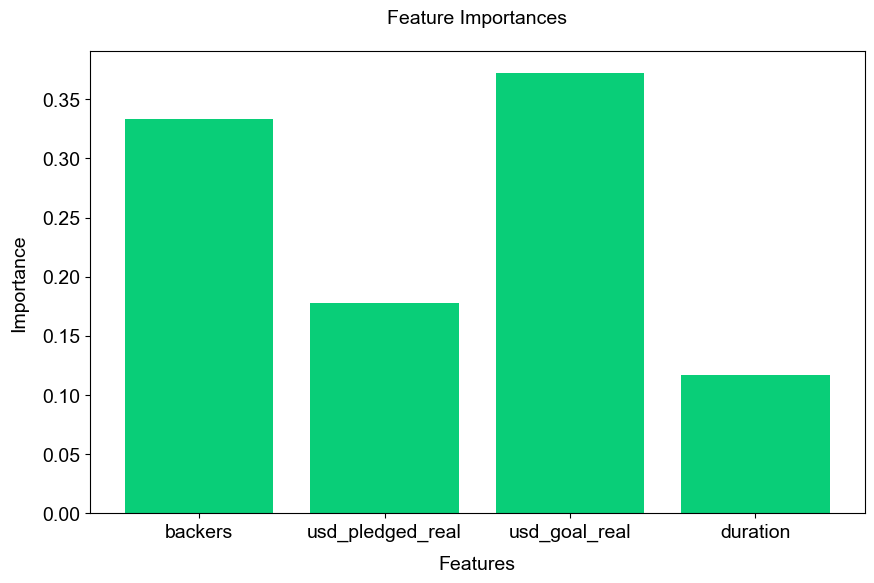

In [13]:
# Feature Importances
features = ['backers', 'usd_pledged_real', 'usd_goal_real', 'duration']
importances = [7505, 3990, 8373, 2632]

# Normalize the importances 
normalized_importances = [i / sum(importances) for i in importances]

# Create a Bar Plot
plt.figure(figsize=(10, 6))
plt.bar(features, normalized_importances, color='#09CE78') # use importances instead of normalized_importances if you want raw values
plt.xlabel('Features', labelpad=10, fontsize=14, fontfamily='arial')
plt.ylabel('Importance', labelpad=10, fontsize=14, fontfamily='arial')
plt.title('Feature Importances', pad=20, fontsize=14, fontfamily='arial')
plt.show()

## Seasonal Decomposition of Time Series Data

In [14]:
## Step 1: Visual Inspection

# Create Copy of the Dataframe
df_seas = df.copy()

# Convert 'launched' to Datetime
df_seas['launched'] = pd.to_datetime(df_seas['launched'])
df_seas['year'] = df_seas['launched'].dt.year
df_seas['month'] = df_seas['launched'].dt.month

# Exclude data from years 2009, 2018, and 2070
df_seas = df_seas[~df_seas['year'].isin([2009, 2018, 2070])]

# Group by Year, Month and get Mean
grouped = df_seas.groupby(['year', 'month']).mean().reset_index()

years = grouped['year'].unique()




/var/folders/4h/ql3s4lyn3x51h67nvgwyxnr80000gn/T/ipykernel_76052/463427845.py:15: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped = df_seas.groupby(['year', 'month']).mean().reset_index()


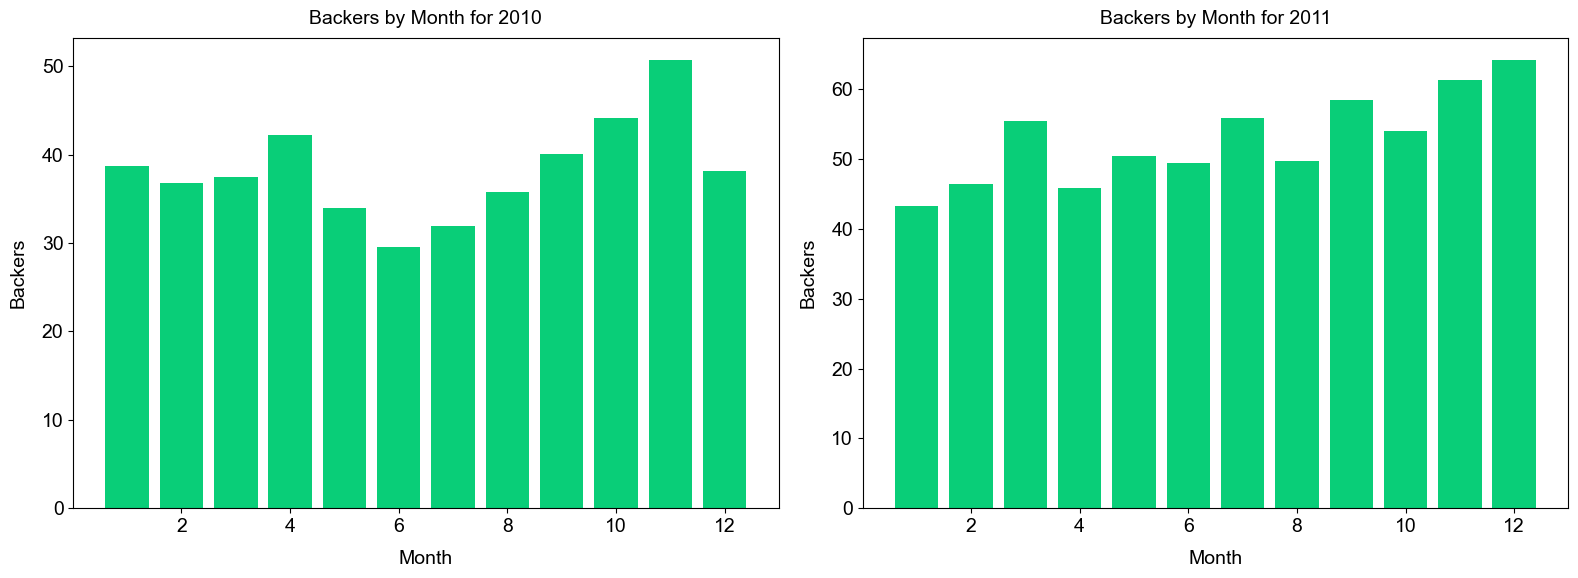

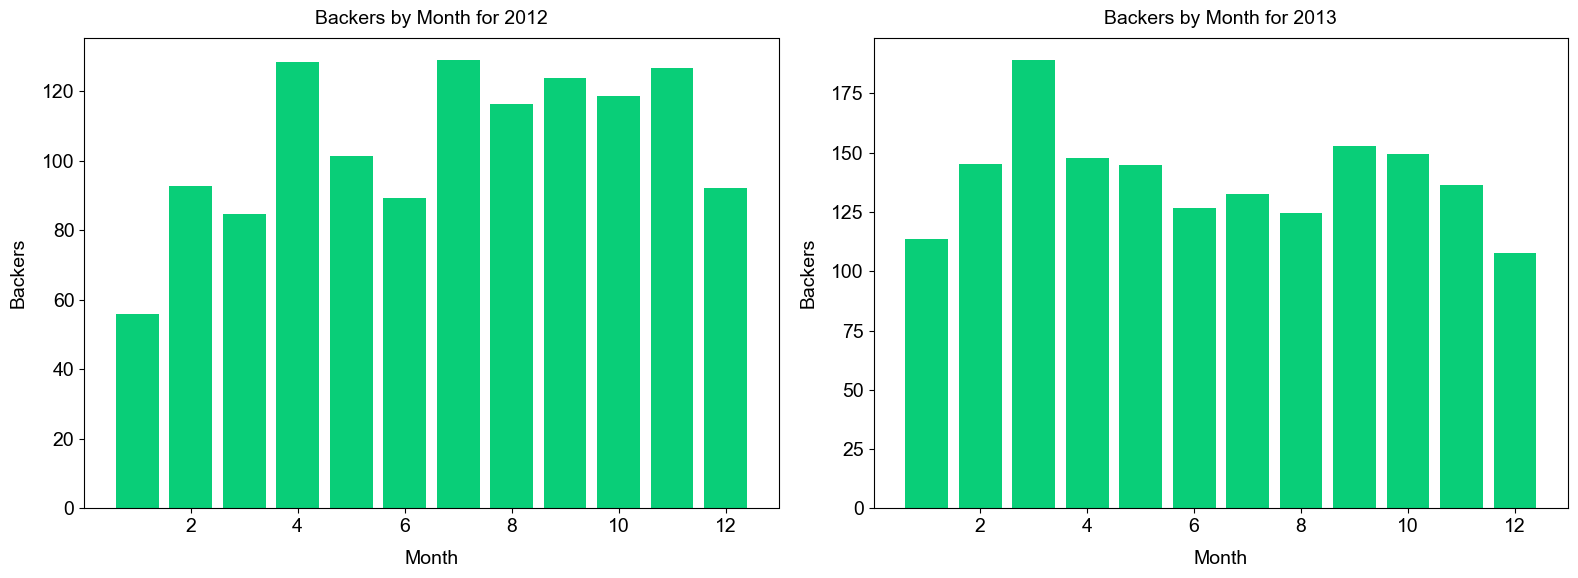

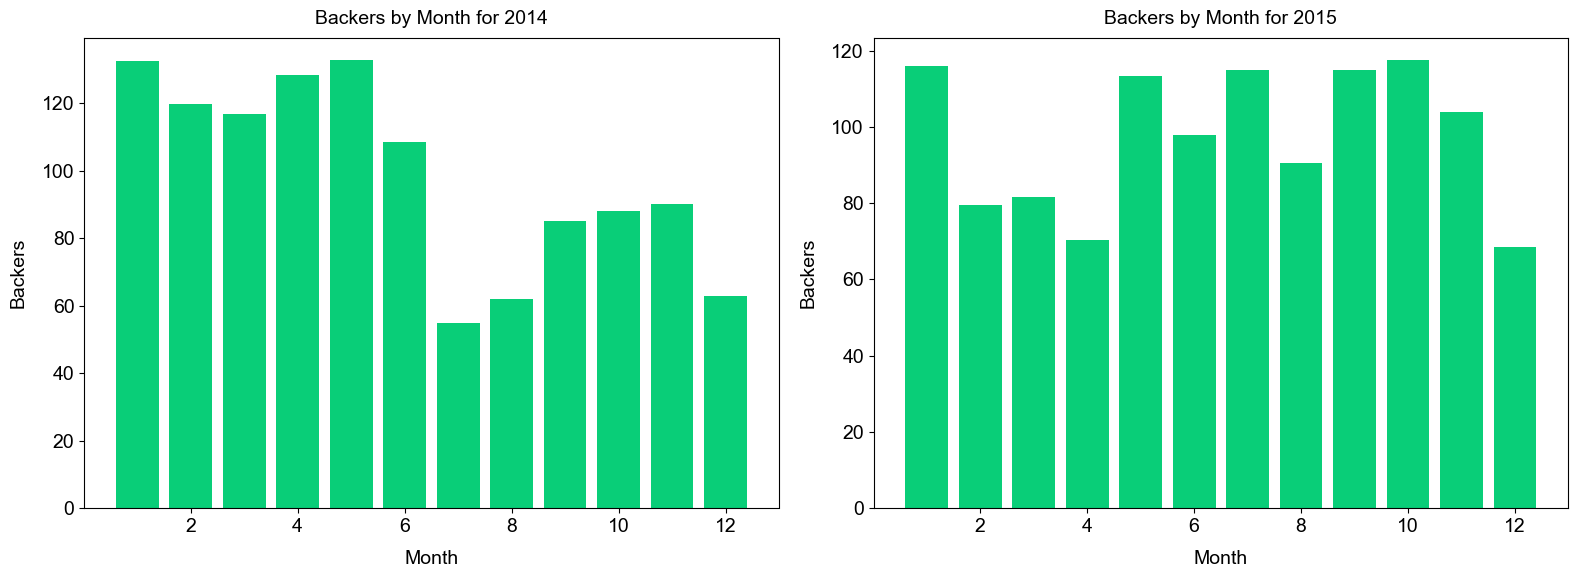

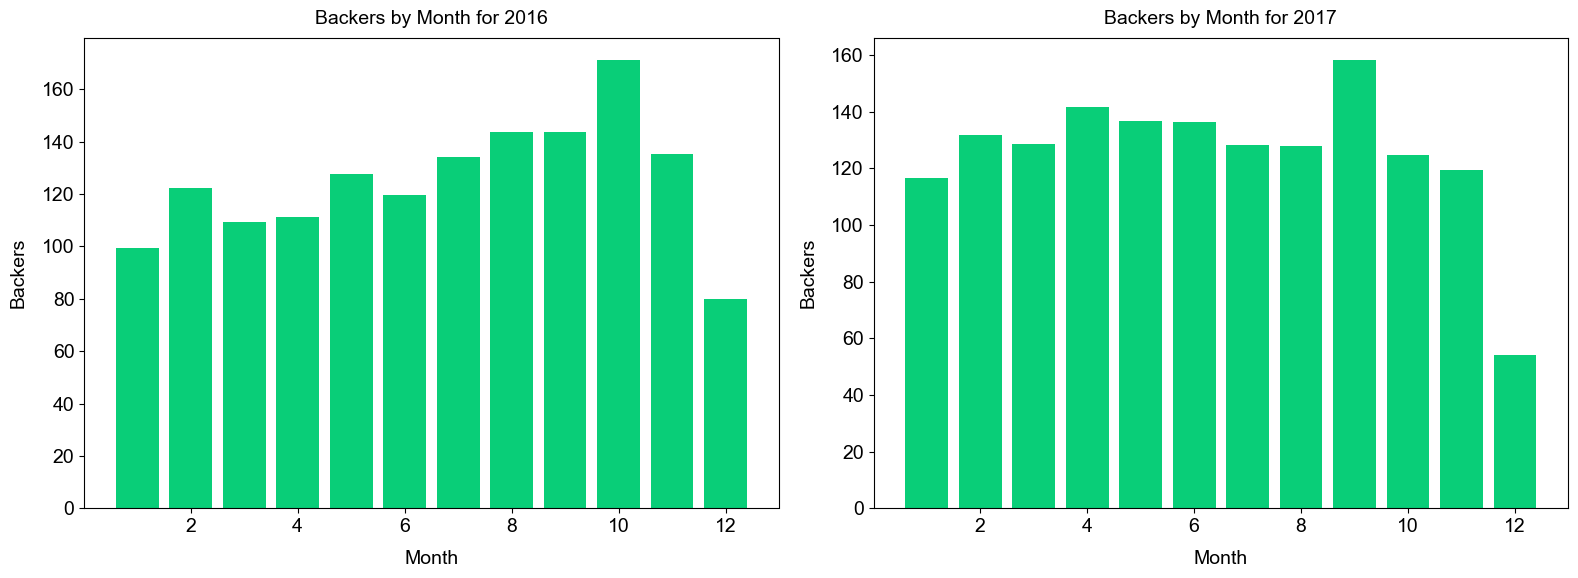

In [15]:
## Backers

# Calculate the number of subplots required
num_subplots = (len(years) + 1) // 2

# Plot Backers for Each Year
for i in range(0, len(years), 2):  
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    yearly_data_1 = grouped[grouped['year'] == years[i]]
    axs[0].bar(yearly_data_1['month'], yearly_data_1['backers'], color='#09CE78')
    axs[0].set_xlabel('Month', fontsize=14, fontfamily='arial', labelpad=10)
    axs[0].set_ylabel('Backers', fontsize=14, fontfamily='arial', labelpad=10)
    axs[0].set_title(f'Backers by Month for {years[i]}', fontsize=14, fontfamily='arial', pad=10)

    if i + 1 < len(years):
        yearly_data_2 = grouped[grouped['year'] == years[i+1]]
        axs[1].bar(yearly_data_2['month'], yearly_data_2['backers'], color='#09CE78')
        axs[1].set_xlabel('Month', fontsize=14, fontfamily='arial', labelpad=10)
        axs[1].set_ylabel('Backers', fontsize=14, fontfamily='arial', labelpad=10)
        axs[1].set_title(f'Backers by Month for {years[i+1]}', fontsize=14, fontfamily='arial', pad=10)
    else:
        fig.delaxes(axs[1])
    
    plt.tight_layout()
    plt.show()

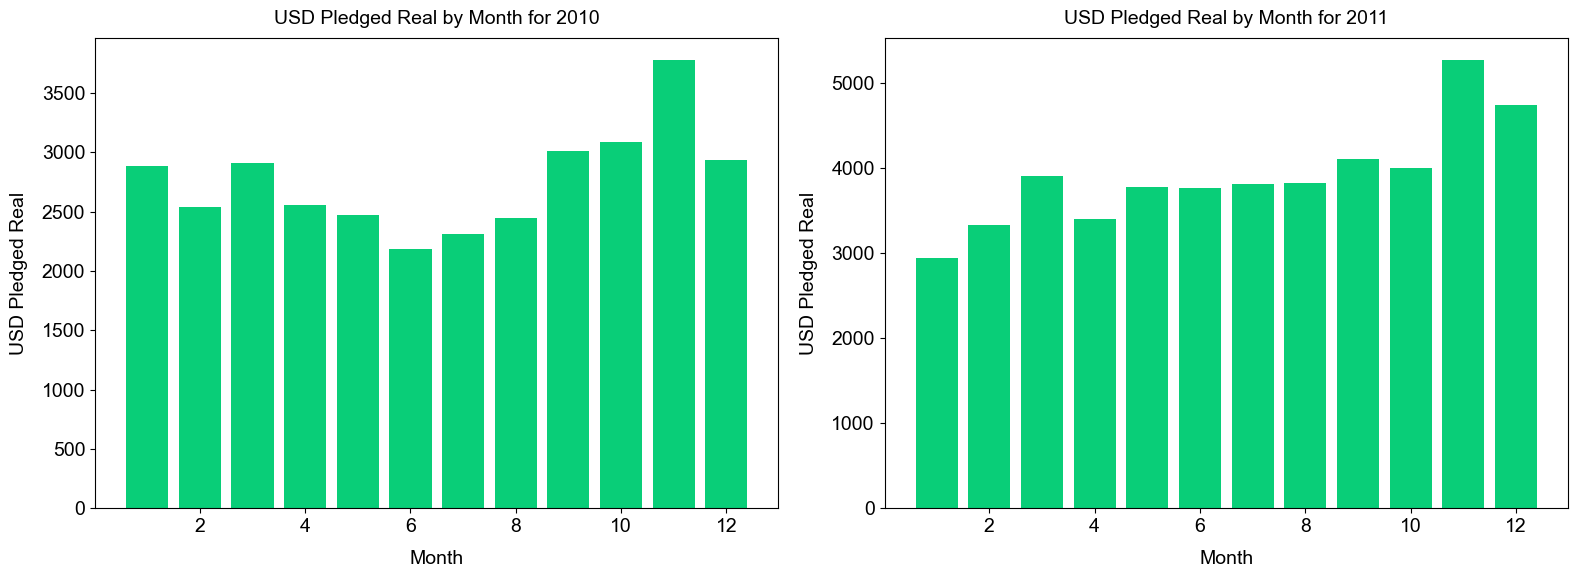

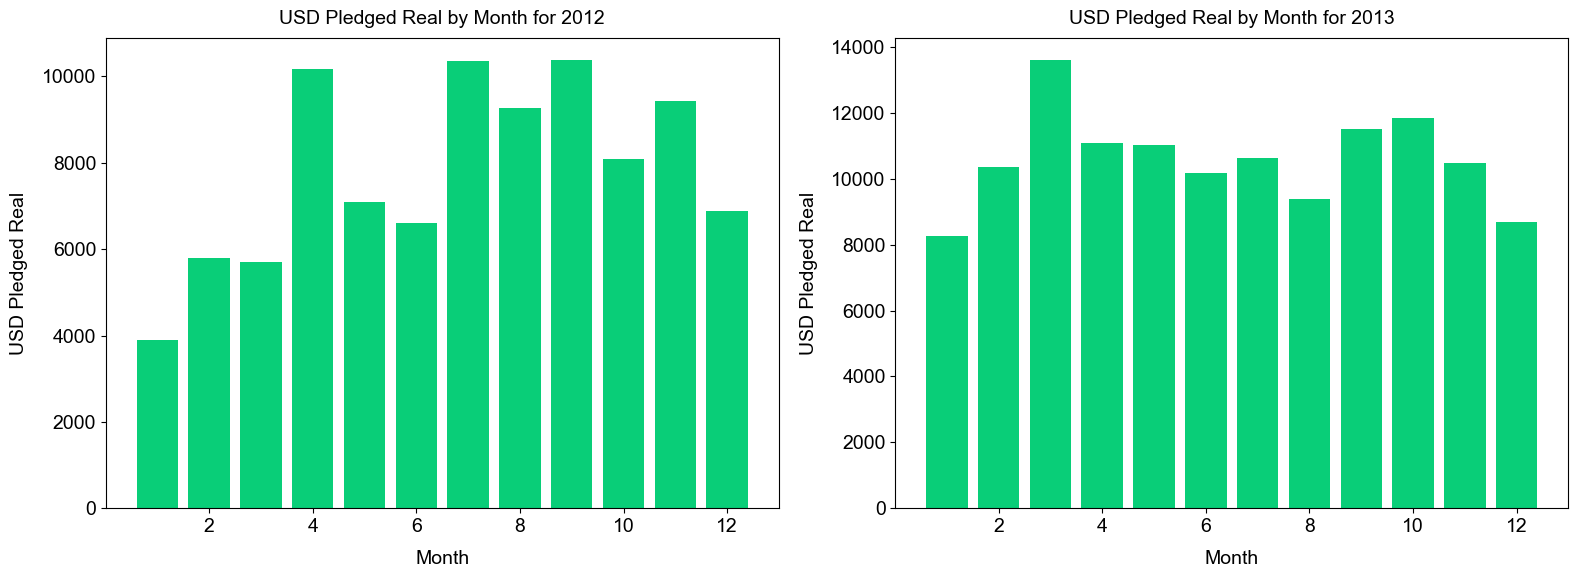

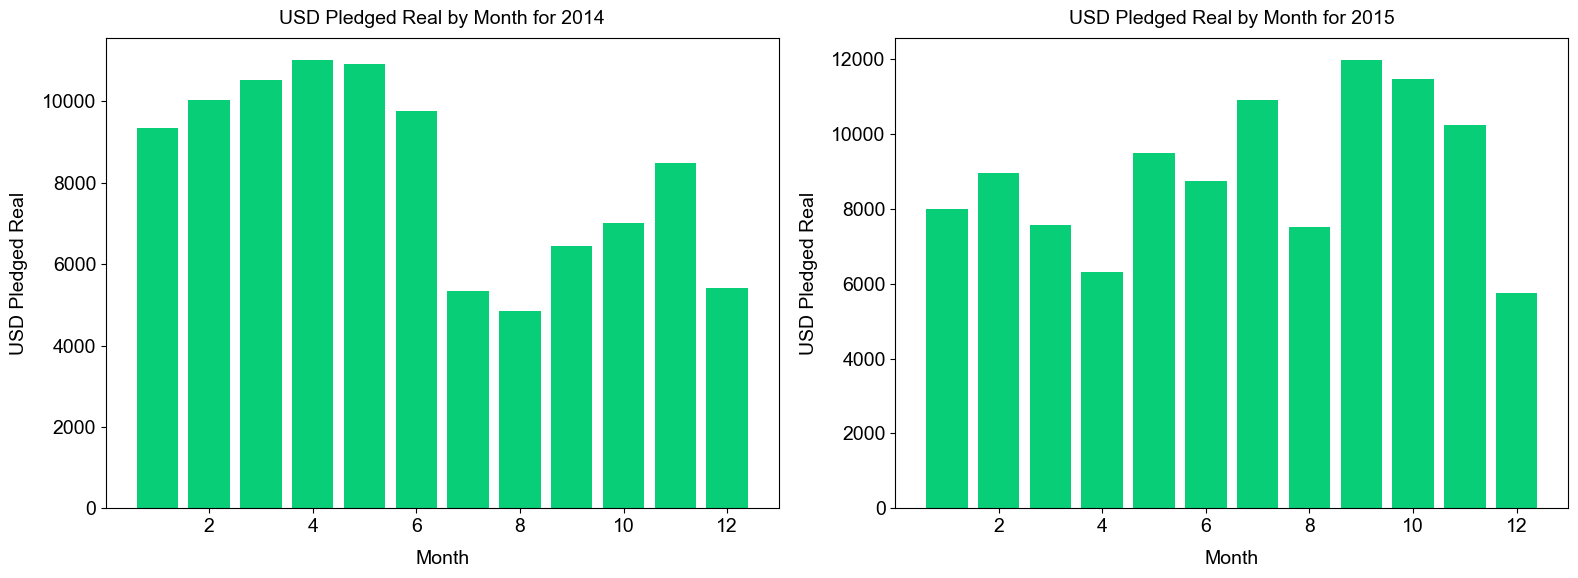

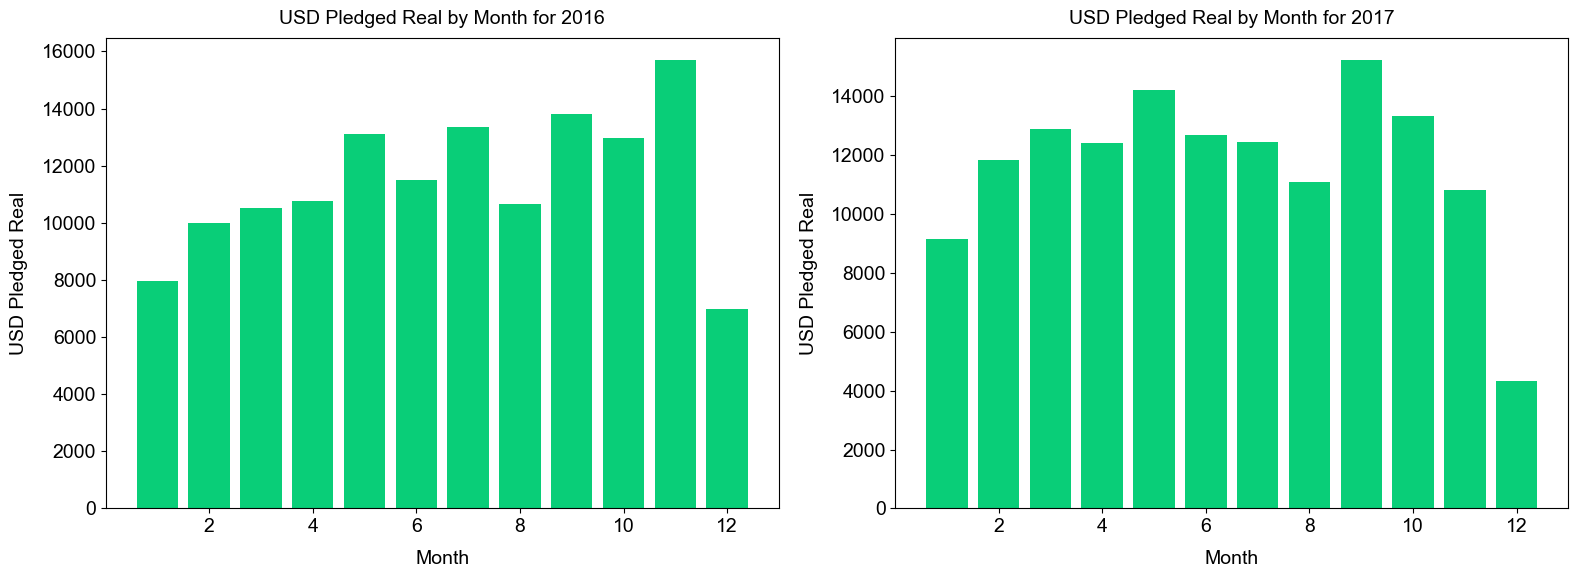

In [16]:
## USD Pledged Real
    
# Calculate the Number of Subplots Required
num_subplots = (len(years) + 1) // 2

# Plot Usd_Pledged_Real for Each Year
for i in range(0, len(years), 2):  
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
   
    yearly_data_1 = grouped[grouped['year'] == years[i]]
    axs[0].bar(yearly_data_1['month'], yearly_data_1['usd_pledged_real'], color='#09CE78')
    axs[0].set_xlabel('Month', fontsize=14, fontfamily='arial', labelpad=10)
    axs[0].set_ylabel('USD Pledged Real', fontsize=14, fontfamily='arial', labelpad=10)
    axs[0].set_title(f'USD Pledged Real by Month for {years[i]}', fontsize=14, fontfamily='arial', pad=10)

   
    if i + 1 < len(years):
        yearly_data_2 = grouped[grouped['year'] == years[i+1]]
        axs[1].bar(yearly_data_2['month'], yearly_data_2['usd_pledged_real'], color='#09CE78')
        axs[1].set_xlabel('Month', fontsize=14, fontfamily='arial', labelpad=10)
        axs[1].set_ylabel('USD Pledged Real', fontsize=14, fontfamily='arial', labelpad=10)
        axs[1].set_title(f'USD Pledged Real by Month for {years[i+1]}', fontsize=14, fontfamily='arial', pad=10)
    else:
        fig.delaxes(axs[1])
    
    plt.tight_layout()
    plt.show()

**Analysis**
1. Both the Backers and USD Pledged Real columns display signs of seasonality that varies every couple of years in a predictable manner.
2. As expected, the recurring pattern in the time series data for the Backers and USD Pledged Real variables appear to be highly correlated; the more Average Backers per month, the greater the Average Pledged Real amount. 
3. For the last three years we have data, 2015, 2016, and 2017, May, July, September, October, and November have the largest average number of monthly Backers and USD Pledged Real. 


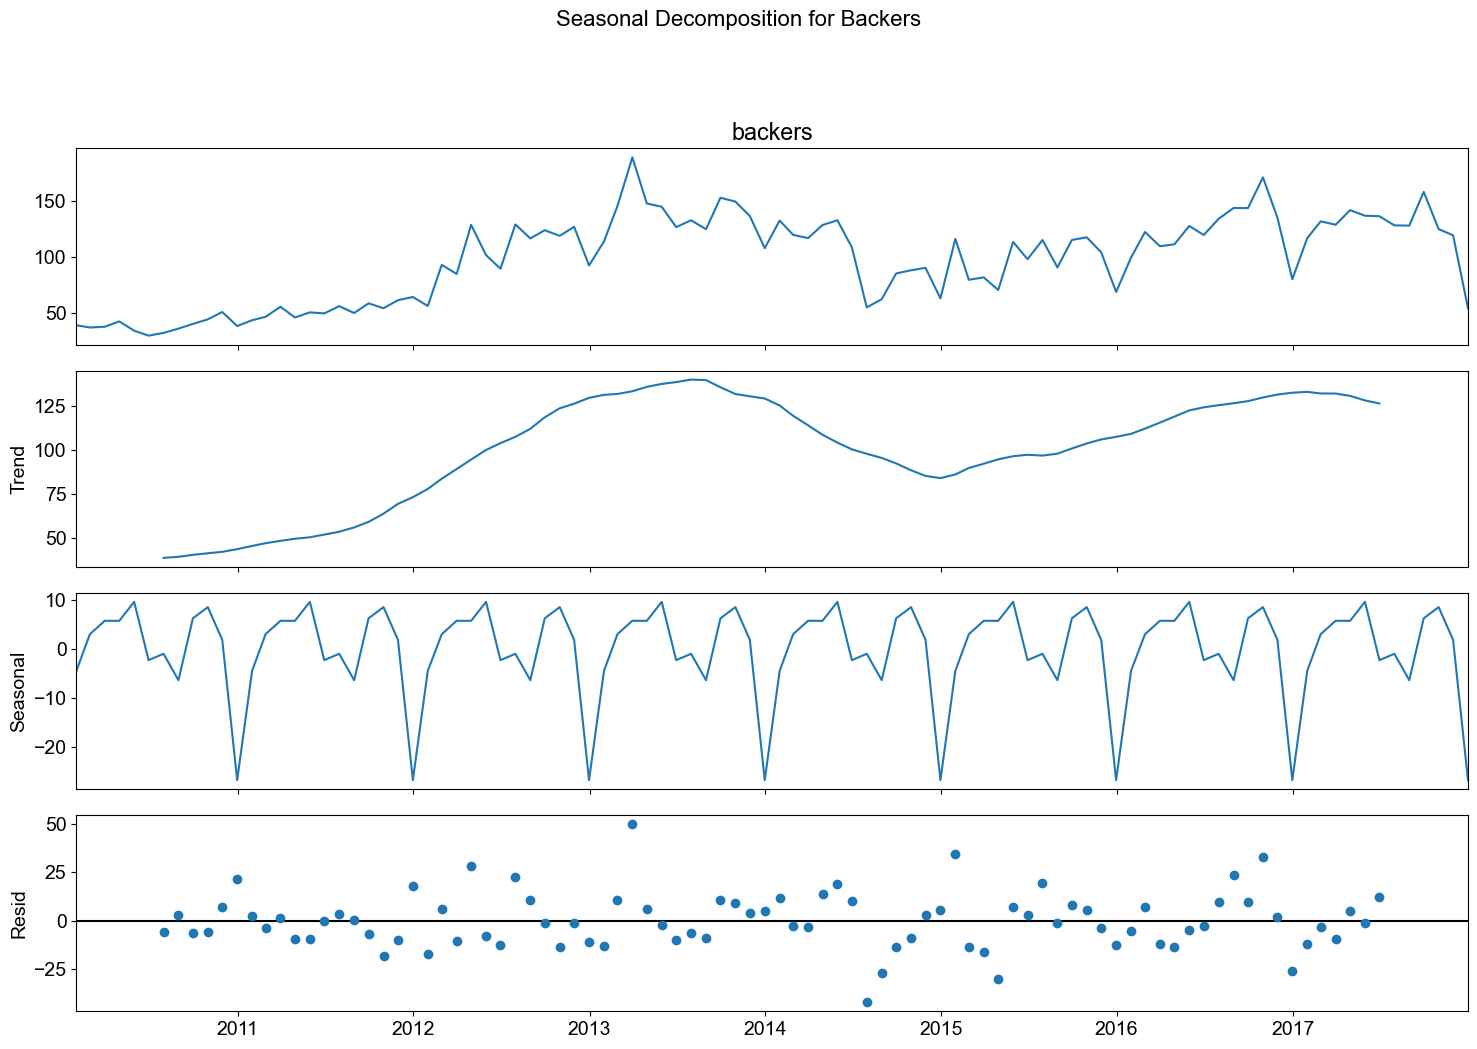

In [17]:
## Seasonal Decomposition for Backers

# Create a Copy
df_seas2 = df.copy()

# Convert 'launched' to Datetime
df_seas2['launched'] = pd.to_datetime(df_seas2['launched'])
df_seas2['year'] = df_seas2['launched'].dt.year
df_seas2['month'] = df_seas2['launched'].dt.month

# Exclude data from years 2009, 2018, and 2070
df_seas2 = df_seas2[~df_seas2['year'].isin([2009, 2018, 2070])]

# Convert Dataframe to a Time Series with a DateTime Index
df_seas2['launched'] = pd.to_datetime(df_seas2['launched'])
df_seas2.set_index('launched', inplace=True)

# Resample to Monthly Data
monthly_backers = df_seas2['backers'].resample('M').mean().fillna(method='ffill')
monthly_usd = df_seas2['usd_pledged_real'].resample('M').mean().fillna(method='ffill')

# Decompose Backers
decomposition_backers = seasonal_decompose(monthly_backers, model='additive')

fig = decomposition_backers.plot()
fig.set_size_inches(15, 10)
for ax in fig.axes:
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis='y')
    ax.tick_params(axis='x')
plt.suptitle('Seasonal Decomposition for Backers', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

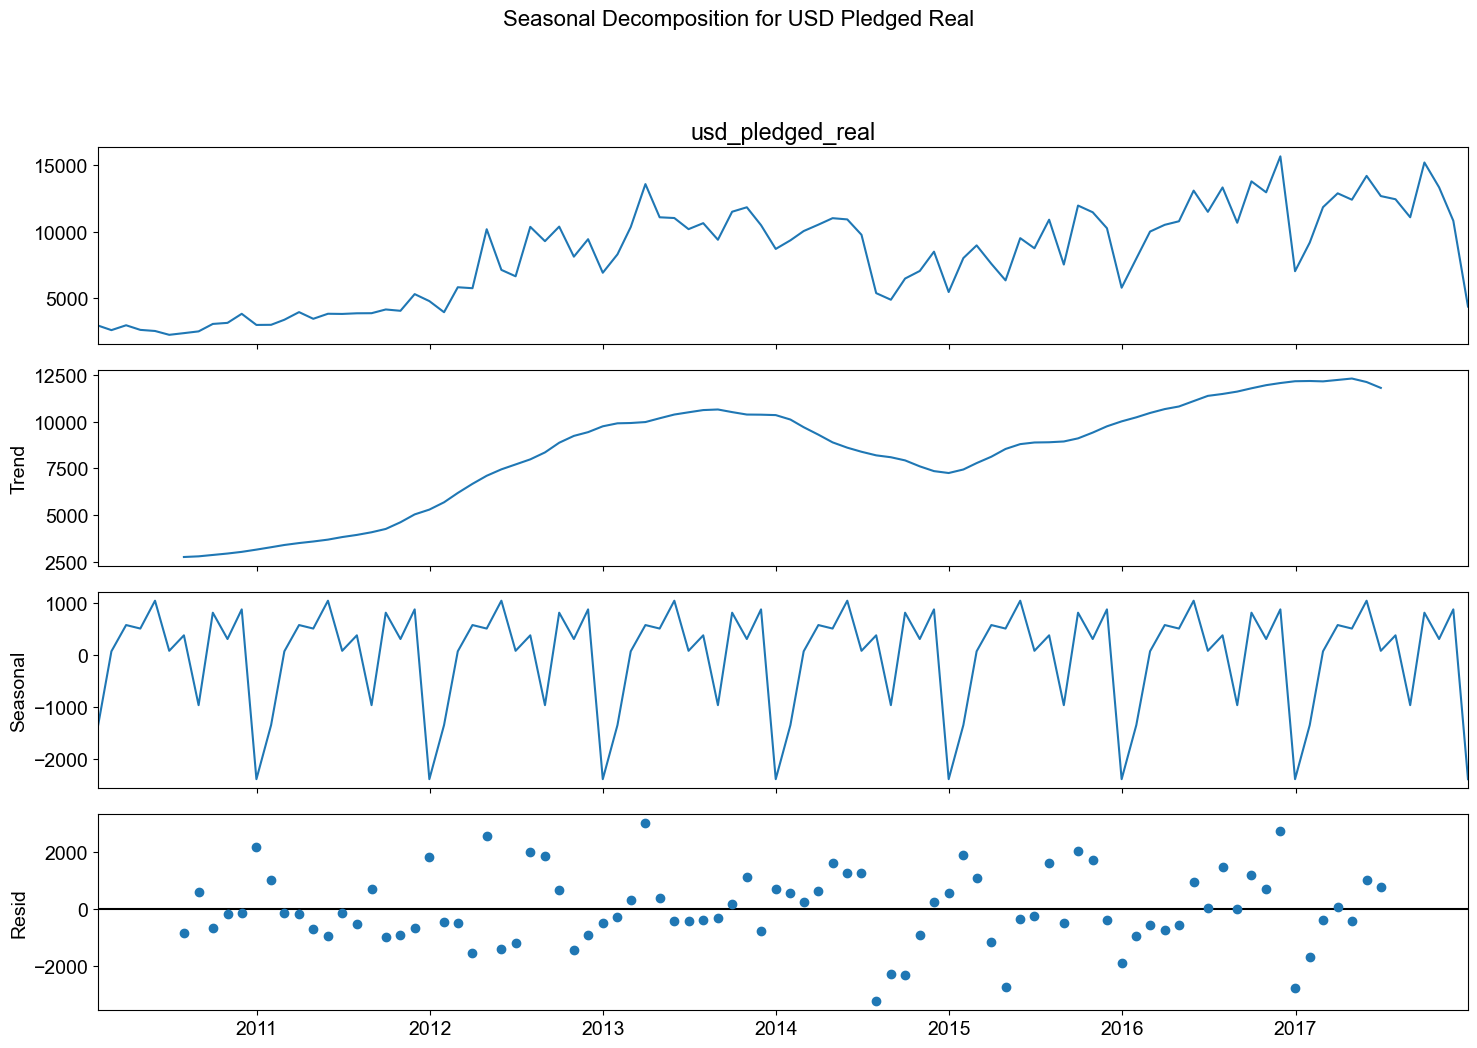

In [18]:
## Seasonal Decomposition for 'usd_pledged_real'

# Resample 'usd_pledged_real' to Monthly Data
monthly_usd = df_seas2['usd_pledged_real'].resample('M').mean().fillna(method='ffill')

# Decompose usd_pledged_real
decomposition_usd = seasonal_decompose(monthly_usd, model='additive')

fig = decomposition_usd.plot()
fig.set_size_inches(15, 10)
for ax in fig.axes:
    ax.set_ylabel(ax.get_ylabel(), fontsize=14)
    ax.tick_params(axis='y')
plt.suptitle('Seasonal Decomposition for USD Pledged Real', fontsize=16, y=1.05)
plt.tight_layout()
plt.show()

**Analysis**
1. Based on the seasonal decomposition of Backers and USD_Pledged Real, both variables show a clear seasonal component with consistent peaks and troughs that repeat in short-term cycles. Seasonality is definately at play. 

## Ad Hoc

In [24]:
# Filter the data for the year 2016
data_2016 = grouped[grouped['year'] == 2016][['month', 'usd_pledged_real']]
data_2016.to_csv('usd_pledged_data_2016.csv')



In [26]:
# Filter the data for the year 2017
data_2017 = grouped[grouped['year'] == 2017][['month', 'usd_pledged_real']]
data_2017.to_csv('usd_pledged_data_2017.csv')

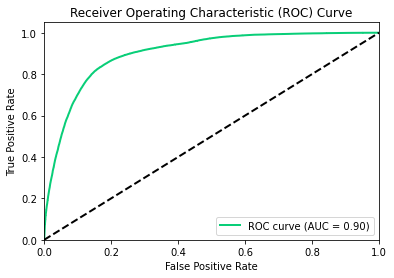

In [94]:
## Logistic Regression Curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# Split the Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=120)

# Create and Fit the Logistic Regression Model
logistic_model = LogisticRegression(random_state=120, class_weight='balanced')
logistic_model.fit(X_train, y_train)

# Make Predictions on the Test Data
y_pred_logistic = logistic_model.predict(X_test)

# Calculate the probability scores for positive class
y_probs = logistic_model.predict_proba(X_test)[:, 1]

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='#09CE78', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [95]:
# Save the plot as an Excel file
df = pd.DataFrame({'False Positive Rate': fpr, 'True Positive Rate': tpr})
df.to_excel('test.xlsx', index=False)